# Aula 26.09
# Exercícios
1) Aumente o número de neurônios nos exemplos de classificação e regressão e analise a diferença entre os resultados nos conjuntos de treino e teste. O que ocorreu?
2) Comparar BCELoss e Hinge Loss para o problema linear do Capítulo 01, plotando o resultado. O que é possível verificar de diferença?

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_regression, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reprodutibilidade
np.random.seed(42)
torch.manual_seed(42)

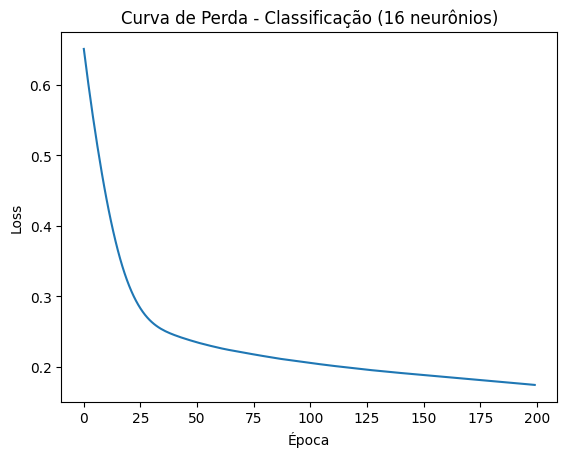

Acurácia no teste (Classificação, 16 neurônios): 0.893


In [4]:
X, y = make_classification(
    n_samples=500, n_features=2, n_informative=2, n_redundant=0,
    n_classes=2, random_state=42
)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Modelo MLP com mais neurônios na camada oculta (capacidade ↑)
class Classifier(nn.Module):
    def __init__(self, hidden_units=16):
        super().__init__()
        self.hidden = nn.Linear(2, hidden_units)
        self.out = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.sigmoid(self.out(x))

model = Classifier(hidden_units=16)
criterion = nn.BCELoss()                 # saída com Sigmoid → BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Curva de perda
plt.plot(losses)
plt.title("Curva de Perda - Classificação (16 neurônios)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.show()

# Acurácia no teste
model.eval()
with torch.no_grad():
    test_probs = model(X_test)
    test_preds = (test_probs > 0.5).float()
    acc = (test_preds.eq(y_test).float().mean().item())

print(f"Acurácia no teste (Classificação, 16 neurônios): {acc:.3f}")

# Observação:
# - Aumentar neurônios ↑ capacidade do modelo.
# - Pode melhorar treino, mas cuidado com overfitting (teste pode não melhorar).


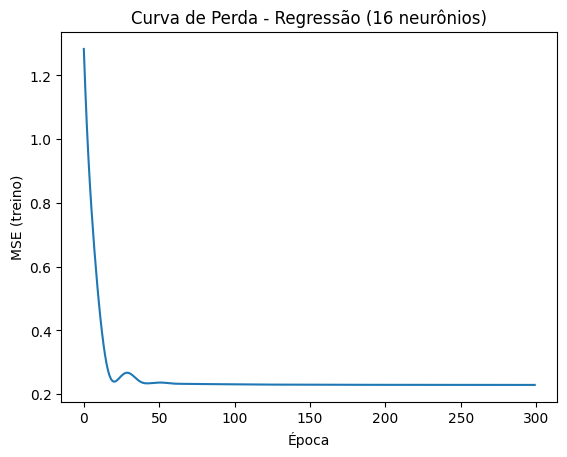

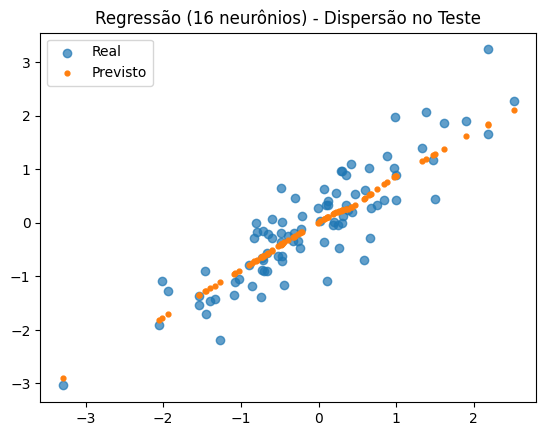

MSE no teste (Regressão, 16 neurônios): 0.2372


In [5]:
X, y = make_regression(n_samples=300, n_features=1, noise=15, random_state=42)

# Normalização (ajuda o treinamento)
scalerX, scalerY = StandardScaler(), StandardScaler()
Xn = scalerX.fit_transform(X)
yn = scalerY.fit_transform(y.reshape(-1, 1))

Xn = torch.tensor(Xn, dtype=torch.float32)
yn = torch.tensor(yn, dtype=torch.float32)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    Xn, yn, test_size=0.3, random_state=42
)

# MLP de regressão com mais neurônios
class Regressor(nn.Module):
    def __init__(self, hidden_units=16):
        super().__init__()
        self.hidden = nn.Linear(1, hidden_units)
        self.out = nn.Linear(hidden_units, 1)
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.out(x)

reg = Regressor(hidden_units=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters(), lr=0.01)

losses = []
for epoch in range(300):
    reg.train()
    optimizer.zero_grad()
    y_pred = reg(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Curva de perda
plt.plot(losses)
plt.title("Curva de Perda - Regressão (16 neurônios)")
plt.xlabel("Época")
plt.ylabel("MSE (treino)")
plt.show()

# Visualização no teste
reg.eval()
with torch.no_grad():
    y_pred_test = reg(X_test)

plt.scatter(X_test.numpy(), y_test.numpy(), label="Real", alpha=0.7)
plt.scatter(X_test.numpy(), y_pred_test.numpy(), label="Previsto", s=12)
plt.legend()
plt.title("Regressão (16 neurônios) - Dispersão no Teste")
plt.show()

# Erro no teste
with torch.no_grad():
    test_mse = criterion(y_pred_test, y_test).item()
print(f"MSE no teste (Regressão, 16 neurônios): {test_mse:.4f}")

# Observação:
# - Mais neurônios ↑ aproximação, mas pode aprender ruído → overfitting.


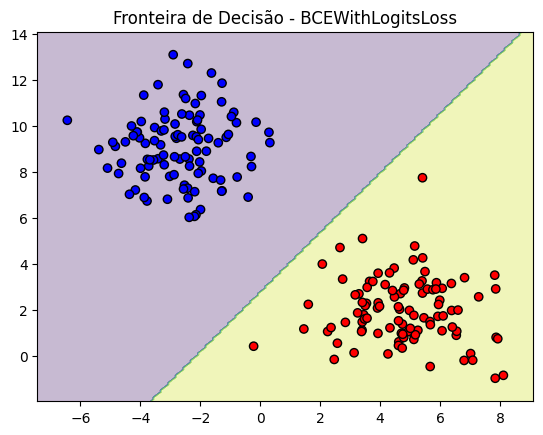

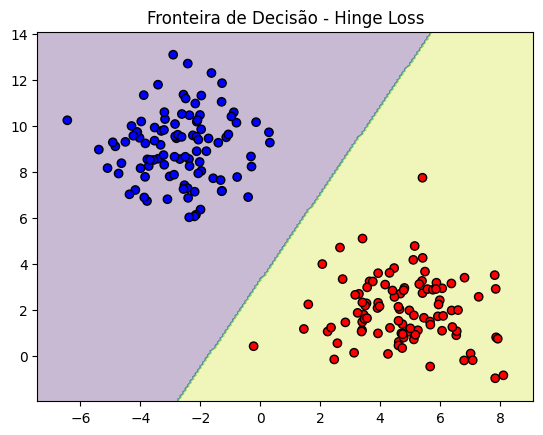

Acurácia (BCEWithLogitsLoss): 1.000
Acurácia (Hinge Loss):       1.000


In [6]:
X, y = make_blobs(n_samples=200, centers=2, cluster_std=1.5, random_state=42)

# Rótulos para cada loss:
y_bce = (y == 1).astype(np.float32).reshape(-1, 1)  # 0/1 para BCE
y_hinge = np.where(y == 0, -1.0, 1.0).reshape(-1, 1)  # -1/1 para Hinge

X_t = torch.tensor(X, dtype=torch.float32)
y_bce_t = torch.tensor(y_bce, dtype=torch.float32)
y_hinge_t = torch.tensor(y_hinge, dtype=torch.float32)

# Modelo linear simples
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 1)
    def forward(self, x):
        return self.fc(x)  # logits

# ---------- Treino com BCEWithLogitsLoss ----------
model_bce = LinearModel()
opt_bce = optim.Adam(model_bce.parameters(), lr=0.01)
bce_loss = nn.BCEWithLogitsLoss()  # usa logits diretamente

for _ in range(200):
    opt_bce.zero_grad()
    logits = model_bce(X_t)
    loss = bce_loss(logits, y_bce_t)
    loss.backward()
    opt_bce.step()

# ---------- Treino com Hinge Loss ----------
model_hinge = LinearModel()
opt_hinge = optim.Adam(model_hinge.parameters(), lr=0.01)

def hinge_loss_fn(outputs, targets):
    # Hinge: mean(max(0, 1 - y * f(x)))  com y ∈ {-1, +1}
    return torch.mean(torch.clamp(1.0 - outputs * targets, min=0.0))

for _ in range(200):
    opt_hinge.zero_grad()
    scores = model_hinge(X_t)  # f(x)
    loss = hinge_loss_fn(scores, y_hinge_t)
    loss.backward()
    opt_hinge.step()

# ---------- Função para plotar fronteira ----------
def plot_boundary(model, X_np, labels01_np, title):
    x_min, x_max = X_np[:, 0].min() - 1.0, X_np[:, 0].max() + 1.0
    y_min, y_max = X_np[:, 1].min() - 1.0, X_np[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    with torch.no_grad():
        logits = model(torch.tensor(grid))
        Z = (logits.numpy() > 0).astype(int).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=labels01_np.flatten(), cmap="bwr", edgecolors="k")
    plt.title(title)
    plt.show()

# Fronteiras
plot_boundary(model_bce, X, y_bce, "Fronteira de Decisão - BCEWithLogitsLoss")
plot_boundary(model_hinge, X, y_bce, "Fronteira de Decisão - Hinge Loss")

# ---------- Métrica de acurácia (ambos) ----------
with torch.no_grad():
    # BCE: logits > 0 ↔ prob > 0.5
    preds_bce = (model_bce(X_t) > 0).float()
    acc_bce = (preds_bce.eq(torch.tensor(y_bce)).float().mean().item())

    # Hinge: mesmo limiar 0 no score linear
    preds_hinge = (model_hinge(X_t) > 0).float()
    acc_hinge = (preds_hinge.eq(torch.tensor(y_bce)).float().mean().item())

print(f"Acurácia (BCEWithLogitsLoss): {acc_bce:.3f}")
print(f"Acurácia (Hinge Loss):       {acc_hinge:.3f}")

# Observações:
# - BCE (logística) modela probabilidade e gera fronteira "suave".
# - Hinge força margem de separação (estilo SVM), fronteira mais "rígida".
# - Em dados linearmente separáveis com margem, Hinge pode se sair muito bem.
